## Imports

In [1]:
import os
import json 
import numpy as np
import pandas as pd

from music21 import *

from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.models import Sequential
from keras.layers import LSTM, Dropout, TimeDistributed, Dense, Activation, Embedding
from keras.callbacks import ModelCheckpoint
from keras.utils import *

## Importing the dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path_directory="/content/drive/MyDrive/Music generation/Data"
path_data_tunes="/content/drive/MyDrive/Music generation/Data/Data_Tunes.txt"
path_char_to_index="/content/drive/MyDrive/Music generation/Data/char_to_index.json"

## Setting the batch size and sequence length

In [4]:
BATCH_SIZE = 16
SEQ_LENGTH = 64

## Data tunes description

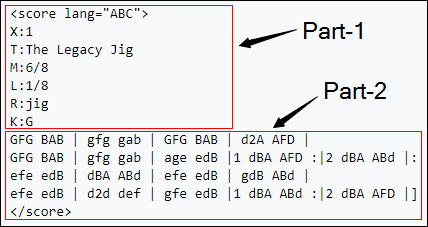

**ABC Notation of music:**

There are two parts in ABC-notation.

**Part-1** represents meta data. Lines in the Part-1 of the tune notation, beginning with a letter followed by a colon, indicate various aspects of the tune such as the index, when there are more than one tune in a file (X:), the title (T:), the time signature (M:), the default note length (L:), the type of tune (R:) and the key (K:).

**Part-2** represents the tune, which is a sequence of characters where each character represents some musical note.

## Preprocessing the tunes

### 1: Removing the part 1 and appending z to the start of each tune

In [5]:
def preprocess(data):
  list1=list(data)
  list2=['\n','\n','\n']
  ignore=['X','T','M','S','K','P']
  i=0
  #to remove Part1:
  while(i<len(list1)):
    if(((list1[i] in ignore) and (list1[i+1]==":"))or list1[i]=='%' ):
      del list2[-1]
      while(list1[i]!='\n'):
        i=i+1
    list2.append(list1[i])
    i=i+1
  i=0
  #to append 'Z'(start token)
  preprocess_data=[]
  while(i<len(list2)):
    if(list2[i]=='\n'and list2[i+1]=='\n' and list2[i+2]=='\n'):
      preprocess_data.append('Z')
      i=i+3
    else:
      preprocess_data.append(list2[i])
      i=i+1
  return preprocess_data

In [6]:
file = open(path_data_tunes, mode = 'r')
data = file.read()
file.close()
data

'X: 1\nT:A and D\n% Nottingham Music Database\nS:EF\nM:4/4\nK:A\nM:6/8\nP:A\nf|"A"ecc c2f|"A"ecc c2f|"A"ecc c2f|"Bm"BcB "E7"B2f|\n"A"ecc c2f|"A"ecc c2c/2d/2|"D"efe "E7"dcB| [1"A"Ace a2:|\n [2"A"Ace ag=g||\\\nK:D\nP:B\n"D"f2f Fdd|"D"AFA f2e/2f/2|"G"g2g ecd|"Em"efd "A7"cBA|\n"D"f^ef dcd|"D"AFA f=ef|"G"gfg "A7"ABc |1"D"d3 d2e:|2"D"d3 d2||\n\n\n\nX: 2\nT:Abacus\n% Nottingham Music Database\nS:By Hugh Barwell, via Phil Rowe\nM:6/8\nK:G\n"G"g2g B^AB|d2d G3|"Em"GAB "Am"A2A|"D7"ABc "G"BAG|\n"G"g2g B^AB|d2d G2G|"Em"GAB "Am"A2G|"D7"FGA "G"G3::\n"D7"A^GA DFA|"G"B^AB G3|"A7"^c=c^c Ace|"D7"fef def|\n"G"g2g de=f|"E7"e2e Bcd|"Am"c2c "D7"Adc| [1"G"B2A G3:|\n [2"G"B2A G2F||"Em"E2E G2G|B2B e2e|"Am"c2A "B7"FBA|"Em"G2F E3|"Em"EFG "Am"ABc|\n"B7"B^c^d "Em"e2e|"F#7"f2f f2e|"B7"^def BAF|"Em"E2E G2G|B2B e2e|\n"Am"c2A "B7"FBA|"Em"G2F E3|"Em"EFG "Am"ABc|"B7"B^c^d "Em"e2e|\n"F#7"f2e "B7"^def |[1"Em"e3 "D7"d3:|[2"Em"e3 "E7"e3||\n\n\nX: 3\nT:The American Dwarf\n% Nottingham Music Database\nS:FTB, via EF\nM:6/8\nK:D

In [7]:
preprocessed_data=preprocess(data)
preprocessed_data

['Z',
 'f',
 '|',
 '"',
 'A',
 '"',
 'e',
 'c',
 'c',
 ' ',
 'c',
 '2',
 'f',
 '|',
 '"',
 'A',
 '"',
 'e',
 'c',
 'c',
 ' ',
 'c',
 '2',
 'f',
 '|',
 '"',
 'A',
 '"',
 'e',
 'c',
 'c',
 ' ',
 'c',
 '2',
 'f',
 '|',
 '"',
 'B',
 'm',
 '"',
 'B',
 'c',
 'B',
 ' ',
 '"',
 'E',
 '7',
 '"',
 'B',
 '2',
 'f',
 '|',
 '\n',
 '"',
 'A',
 '"',
 'e',
 'c',
 'c',
 ' ',
 'c',
 '2',
 'f',
 '|',
 '"',
 'A',
 '"',
 'e',
 'c',
 'c',
 ' ',
 'c',
 '2',
 'c',
 '/',
 '2',
 'd',
 '/',
 '2',
 '|',
 '"',
 'D',
 '"',
 'e',
 'f',
 'e',
 ' ',
 '"',
 'E',
 '7',
 '"',
 'd',
 'c',
 'B',
 '|',
 ' ',
 '[',
 '1',
 '"',
 'A',
 '"',
 'A',
 'c',
 'e',
 ' ',
 'a',
 '2',
 ':',
 '|',
 '\n',
 ' ',
 '[',
 '2',
 '"',
 'A',
 '"',
 'A',
 'c',
 'e',
 ' ',
 'a',
 'g',
 '=',
 'g',
 '|',
 '|',
 '\\',
 '\n',
 '"',
 'D',
 '"',
 'f',
 '2',
 'f',
 ' ',
 'F',
 'd',
 'd',
 '|',
 '"',
 'D',
 '"',
 'A',
 'F',
 'A',
 ' ',
 'f',
 '2',
 'e',
 '/',
 '2',
 'f',
 '/',
 '2',
 '|',
 '"',
 'G',
 '"',
 'g',
 '2',
 'g',
 ' ',
 'e',
 'c',
 'd',
 '|',


### 2: Mapping the above data to its corresponding indices


Returns all_characters_as_indices i.e an array containing all characters of the dataset replaced with their corresponding indices as per the vocabulary.
Also returns num_unique_chars i.e an integer equal to number of unique characters in the data.

In [8]:
def read_data(preprocess_data):
  char_to_index = {ch: i for (i, ch) in enumerate(sorted(list(set(preprocess_data))))}
  unique_chars = [ch for (i, ch) in enumerate(sorted(list(set(preprocess_data))))]
    
  with open(path_char_to_index, mode = "w") as f:
        json.dump(char_to_index, f)
        
  index_to_char = {i: ch for (ch, i) in char_to_index.items()}
  num_unique_chars = len(char_to_index)
  all_characters_as_indices = np.asarray([char_to_index[c] for c in preprocess_data], dtype = np.int32)
  return all_characters_as_indices,num_unique_chars,unique_chars


In [9]:
all_characters_as_indices,num_unique_chars,unique_chars=read_data(preprocessed_data)
unique_chars

['\n',
 ' ',
 '!',
 '"',
 '#',
 "'",
 '(',
 ')',
 '+',
 ',',
 '-',
 '/',
 '1',
 '2',
 '3',
 '4',
 '6',
 '7',
 '8',
 '9',
 ':',
 '=',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'L',
 'R',
 'V',
 'Z',
 '[',
 '\\',
 ']',
 '^',
 '_',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'i',
 'l',
 'm',
 'n',
 'o',
 'p',
 'r',
 's',
 't',
 'u',
 'z',
 '|',
 '~']

### 3: Extracting the input X and output Y

We split the entire list into examples each of length SEQ_LENGTH. This is X (input): size of X is num_examples x SEQ_LENGTH. For each X[i,j], we store its next character in Y in one-hot-encoded form: size of Y is num_examples x SEQ_LENGTH x num_unique_characters

In [10]:
def input_output(all_chars_as_indices,num_unique_chars):
    total_length = all_chars_as_indices.shape[0]
    num_examples=int(total_length/SEQ_LENGTH)
    X=np.zeros((num_examples,SEQ_LENGTH))
    Y=np.zeros((num_examples,SEQ_LENGTH,num_unique_chars))
    for i in range(num_examples): 
      for j in range(SEQ_LENGTH):
        X[i,j]=all_chars_as_indices[i*SEQ_LENGTH+j]
        Y[i,j,all_chars_as_indices[i*SEQ_LENGTH+j+1]]=1
    return X,Y

In [11]:
X,Y = input_output(all_characters_as_indices,num_unique_chars)

In [12]:
X.shape

(1827, 64)

In [13]:
Y.shape

(1827, 64, 59)

## Building the model

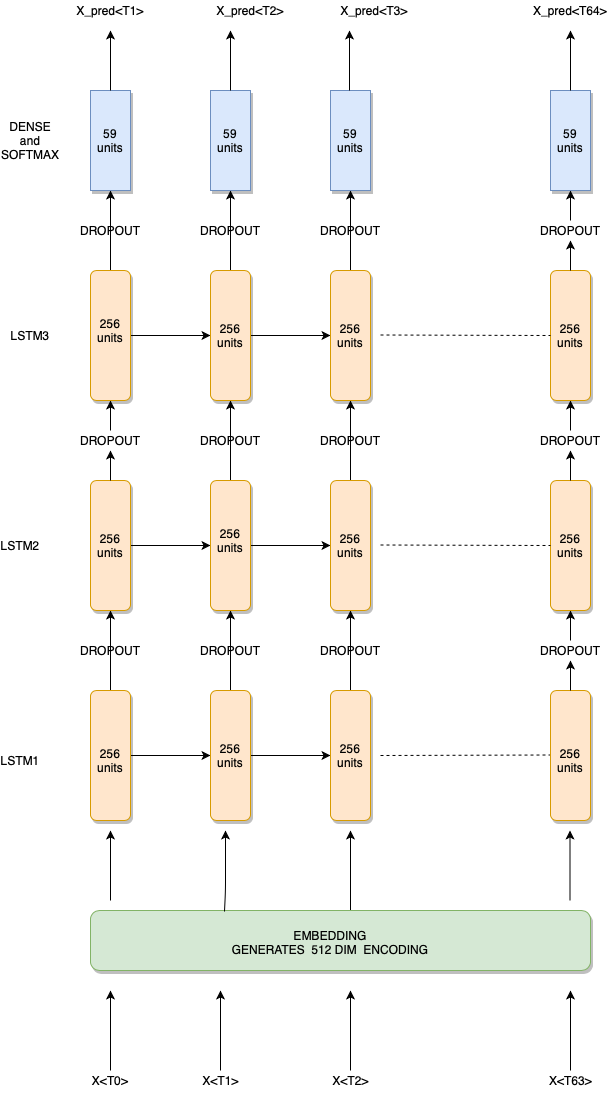

In [14]:
def build_model( seq_length, num_unique_chars):
    model = Sequential()
    
    model.add(Embedding(input_dim = num_unique_chars, output_dim = 512, input_shape = (seq_length,))) 
    
    model.add(LSTM(256, return_sequences = True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(256, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(256, return_sequences = True))
    model.add(Dropout(0.2))
    
        
    model.add(TimeDistributed(Dense(num_unique_chars)))

    model.add(Activation("softmax"))
    
    return model

A small modification:

stateful: If True, the last state for each sample at index i in a batch will be used as initial state for the sample of index i in the following batch.

In [15]:
def make_model(num_unique_chars):
    model = Sequential()
    
    model.add(Embedding(input_dim = num_unique_chars, output_dim = 512, batch_input_shape = (1, 1))) 
  

    model.add(LSTM(256, return_sequences = True, stateful = True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(256, return_sequences = True, stateful = True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(256,return_sequences=True, stateful = True)) 
    model.add(Dropout(0.2))
    
    model.add((Dense(num_unique_chars)))
    model.add(Activation("softmax"))
    
    return model

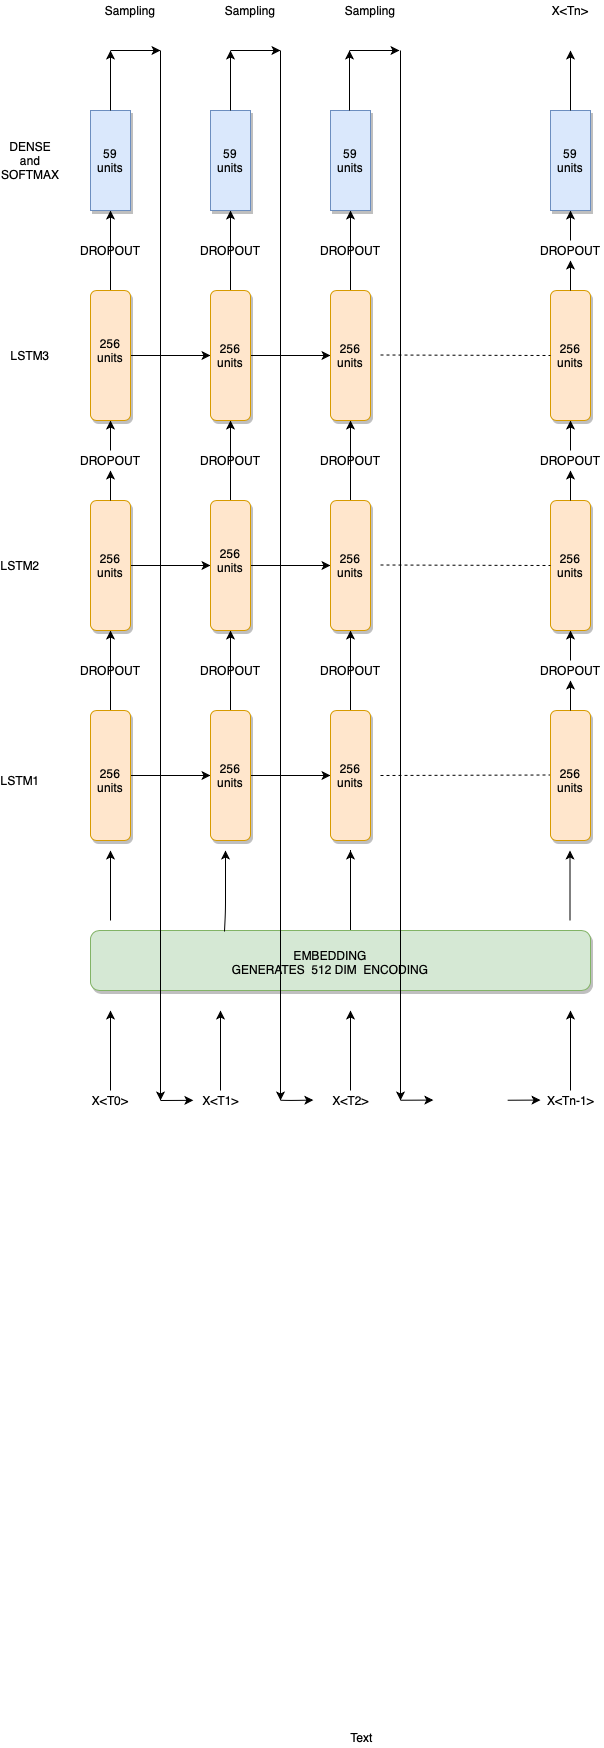

In [16]:
model=build_model(SEQ_LENGTH,num_unique_chars)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 64, 512)           30208     
                                                                 
 lstm (LSTM)                 (None, 64, 256)           787456    
                                                                 
 dropout (Dropout)           (None, 64, 256)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64, 256)           525312    
                                                                 
 dropout_1 (Dropout)         (None, 64, 256)           0         
                                                                 
 lstm_2 (LSTM)               (None, 64, 256)           525312    
                                                                 
 dropout_2 (Dropout)         (None, 64, 256)           0

In [ ]:
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
checkpoint=ModelCheckpoint(filepath='weights.{epoch:02d}.hdf5',monitor='loss',save_best_only=True,save_weights_only=True,period=1)
model.fit(X,Y,batch_size=16,epochs=80,callbacks=[checkpoint])

Epoch 1/80
115/115 [==============================] - 11s 16ms/step - loss: 3.0899 - accuracy: 0.1841
Epoch 2/80
115/115 [==============================] - 2s 16ms/step - loss: 2.2292 - accuracy: 0.3795
Epoch 3/80
115/115 [==============================] - 2s 16ms/step - loss: 1.8500 - accuracy: 0.4482
Epoch 4/80
115/115 [==============================] - 2s 16ms/step - loss: 1.6785 - accuracy: 0.4747
Epoch 5/80
115/115 [==============================] - 2s 16ms/step - loss: 1.5760 - accuracy: 0.4930
Epoch 6/80
115/115 [==============================] - 2s 15ms/step - loss: 1.5161 - accuracy: 0.5076
Epoch 7/80
115/115 [==============================] - 2s 15ms/step - loss: 1.4601 - accuracy: 0.5236
Epoch 8/80
115/115 [==============================] - 2s 15ms/step - loss: 1.4153 - accuracy: 0.5373
Epoch 9/80
115/115 [==============================] - 2s 16ms/step - loss: 1.3657 - accuracy: 0.5519
Epoch 10/80
115/115 [==============================] - 2s 16ms/step - loss: 1.3261 - accur

## Generating music

In [ ]:
# Function which generates music sequences of length=gen_seq_length.
def generate_sequence(gen_seq_length,char):
    with open(path_char_to_index) as f:
        char_to_index = json.load(f)
    index_to_char = {i:ch for ch, i in char_to_index.items()}
    num_unique_chars = len(index_to_char)
    
    model = make_model(num_unique_chars)
    model.load_weights("/content/weights.80.hdf5")
     
    sequence_index = [char_to_index['Z'],char_to_index[char]]

    for _ in range(gen_seq_length):
        batch = np.zeros((1, 1))
        batch[0, 0] = sequence_index[-1]
        
        predicted_probs = model.predict_on_batch(batch).ravel()
        sample = np.random.choice(range(num_unique_chars), size = 1, p = predicted_probs)
        
        
        sequence_index.append(sample[0])
    
        
    
    seq = ''.join(index_to_char[c] for c in sequence_index)
    seq='M:6/8\n'+str(seq)
    return seq

In [ ]:
# function to create a midi file given a music sequence in abc notation.
def convert_to_midi(abc):
    c = converter.subConverters.ConverterABC()
    c.registerOutputExtensions = ("midi", )
    c.parseData(abc)
    s = c.stream
    s.write('midi', fp='demos1.mid')

In [ ]:
music = generate_sequence(192,'G')
print("\nMUSIC SEQUENCE GENERATED: \n{}".format(music))
convert_to_midi(music)